# CONVNET + DEEP CLUSTERING + BRAIN TUMOR

In [18]:
# ! pip install torch torchvision numpy pydantic interpret faiss-cpu torchsummary matplotlib pandas seaborn scikit-learn scikit-image pytorch-lightning[extra] --no-cache-dir --ignore-installed

In [19]:
import copy
import os
import pickle
import logging
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from data.brain_tumor_mri import BrainTumorMRI
from models.cnn_deep import DConvNet
from pytorch_lightning import Trainer, seed_everything

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import Timer
from pytorch_lightning.callbacks import RichProgressBar

from pytorch_lightning.loggers import CSVLogger
from torchvision import transforms
from torchvision.transforms import functional as F

from helpers.prediction import get_labels_from_prediction
from helpers.metrics import dmetrics_to_dataframe
from report.plots import plot_loss_curve, plot_acc_curve, plot_analysis, plot_clustering_metrics
from report import basic_report

seed_everything(42, workers=True)
pd.set_option('display.max_rows', None)

Global seed set to 42


In [20]:
BATCH_SIZE = 64
VAL_SIZE = 0.3
EPOCHS = 60
DATASET_RANDOM = 37

brain_tumor = BrainTumorMRI(val_size=VAL_SIZE, batch_size=BATCH_SIZE, random_state=DATASET_RANDOM, transformations=transforms.Compose(
            [
                transforms.Resize((255, 255)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        ))

# MODEL

In [21]:
model = DConvNet(dataset=brain_tumor, num_classes=4, freeze=False)

timer = Timer()
progress_bar = RichProgressBar()
logger = CSVLogger(save_dir="./", name=f"experiments-1/{model.name}", flush_logs_every_n_steps=1)
checkpoint_callback = ModelCheckpoint(
    filename=f"{model.name}-" + "{epoch}-{train_loss:.4f}-{train_acc:.4f}-{val_loss:.4f}-{val_acc:.4f}",
    save_top_k=3, save_last=True, monitor="val_loss", mode="min", verbose=True
)

trainer = Trainer(
    accelerator="auto", 
    devices="auto",
    max_epochs=EPOCHS,
    logger=logger,
    callbacks=[timer, progress_bar, checkpoint_callback],
    log_every_n_steps=1,    
    # enable_progress_bar=False,
    # limit_train_batches=DATASET_RATIO or 1.0,
    # limit_val_batches=DATASET_RATIO or 1.0,
    # limit_test_batches=DATASET_RATIO or 1.0
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## TRAINING

In [22]:
trainer.fit(
    model,
    train_dataloaders=brain_tumor.train_dataloader,
    val_dataloaders=brain_tumor.val_dataloader
)

┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ loss_fn   │ CrossEntropyLoss   │      0 │
│ 1 │ train_acc │ MulticlassAccuracy │      0 │
│ 2 │ val_acc   │ MulticlassAccuracy │      0 │
│ 3 │ test_acc  │ MulticlassAccuracy │      0 │
│ 4 │ model     │ ConvNet            │ 16.3 M │
└───┴───────────┴────────────────────┴────────┘

Trainable params: 16.3 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 16.3 M                                                                                               
Total estimated model params size (MB): 65

Output()

Epoch 0

Feature extracting elapsed time: 49.0307 seconds.

Clustering elapsed time: 0.6630 seconds.

Epoch 0, global step 63: 'val_loss' reached 0.58442 (best 0.58442), saving model to './experiments-1/dconvnet/version_1/checkpoints/dconvnet-epoch=0-train_loss=0.8890-train_acc=0.6541-val_loss=0.5844-val_acc=0.7911.ckpt' as top 3


Epoch 1

Creating dataset from Clustering elapsed time: 21.9998 seconds.

Feature extracting elapsed time: 58.3472 seconds.

Clustering elapsed time: 0.5543 seconds.

Metrics: {'clu_homogeneity_score': 0.000792900827023255, 'clu_completeness_score': 0.0008363857948718848, 
'clu_v_measure_score': 0.0008140630132874207, 'clu_adjusted_rand_score': -0.0024971052385669872, 
'clu_adjusted_mutual_info_score': -9.589053833244063e-05}

Epoch 1, global step 126: 'val_loss' reached 0.65149 (best 0.58442), saving model to './experiments-1/dconvnet/version_1/checkpoints/dconvnet-epoch=1-train_loss=0.8597-train_acc=0.6673-val_loss=0.6515-val_acc=0.7322.ckpt' as top 3


Epoch 2

Creating dataset from Clustering elapsed time: 21.9482 seconds.

Feature extracting elapsed time: 58.5276 seconds.

Clustering elapsed time: 0.7252 seconds.

Metrics: {'clu_homogeneity_score': 0.863722412131303, 'clu_completeness_score': 0.8628214967352145, 
'clu_v_measure_score': 0.8632717193831836, 'clu_adjusted_rand_score': 0.9141396421199983, 
'clu_adjusted_mutual_info_score': 0.8631437880385143}

Epoch 2, global step 189: 'val_loss' reached 0.60625 (best 0.58442), saving model to './experiments-1/dconvnet/version_1/checkpoints/dconvnet-epoch=2-train_loss=0.9478-train_acc=0.6443-val_loss=0.6062-val_acc=0.7690.ckpt' as top 3


Epoch 3

Creating dataset from Clustering elapsed time: 23.0167 seconds.

Feature extracting elapsed time: 60.2818 seconds.

Clustering elapsed time: 0.6768 seconds.

Metrics: {'clu_homogeneity_score': 0.8701945121061879, 'clu_completeness_score': 0.8797796406290609, 
'clu_v_measure_score': 0.8749608260688253, 'clu_adjusted_rand_score': 0.9206522940128133, 
'clu_adjusted_mutual_info_score': 0.8748432393475378}

Epoch 3, global step 252: 'val_loss' was not in top 3


Epoch 4

Creating dataset from Clustering elapsed time: 24.1288 seconds.

Feature extracting elapsed time: 62.0485 seconds.

Clustering elapsed time: 0.6179 seconds.

Metrics: {'clu_homogeneity_score': 0.8666095731054042, 'clu_completeness_score': 0.8680115002322323, 
'clu_v_measure_score': 0.86730997014749, 'clu_adjusted_rand_score': 0.9088563120139252, 
'clu_adjusted_mutual_info_score': 0.8671843708094824}

Epoch 4, global step 315: 'val_loss' was not in top 3


Epoch 5

Creating dataset from Clustering elapsed time: 23.7144 seconds.

Feature extracting elapsed time: 62.1150 seconds.

Clustering elapsed time: 0.7272 seconds.

Metrics: {'clu_homogeneity_score': 0.7651765830653741, 'clu_completeness_score': 0.8144242999370542, 
'clu_v_measure_score': 0.7890327356702124, 'clu_adjusted_rand_score': 0.862729532045869, 
'clu_adjusted_mutual_info_score': 0.7888261613495503}

Epoch 5, global step 378: 'val_loss' reached 0.63041 (best 0.58442), saving model to './experiments-1/dconvnet/version_1/checkpoints/dconvnet-epoch=5-train_loss=0.8921-train_acc=0.6276-val_loss=0.6304-val_acc=0.7433.ckpt' as top 3


Epoch 6

Creating dataset from Clustering elapsed time: 24.0749 seconds.

Feature extracting elapsed time: 62.6215 seconds.

Clustering elapsed time: 0.6809 seconds.

Metrics: {'clu_homogeneity_score': 0.8556748097252831, 'clu_completeness_score': 0.8558839804491117, 
'clu_v_measure_score': 0.8557793823057516, 'clu_adjusted_rand_score': 0.9054393562947723, 
'clu_adjusted_mutual_info_score': 0.8556327303773927}

Epoch 6, global step 441: 'val_loss' was not in top 3


Epoch 7

Creating dataset from Clustering elapsed time: 24.3869 seconds.

Feature extracting elapsed time: 63.4091 seconds.

Clustering elapsed time: 0.7535 seconds.

Metrics: {'clu_homogeneity_score': 0.8285277486305136, 'clu_completeness_score': 0.8361680803052255, 
'clu_v_measure_score': 0.8323303813344631, 'clu_adjusted_rand_score': 0.8685516360214108, 
'clu_adjusted_mutual_info_score': 0.8321588926164838}

Epoch 7, global step 504: 'val_loss' reached 0.60675 (best 0.58442), saving model to './experiments-1/dconvnet/version_1/checkpoints/dconvnet-epoch=7-train_loss=0.8468-train_acc=0.6821-val_loss=0.6067-val_acc=0.7497.ckpt' as top 3


Epoch 8

Creating dataset from Clustering elapsed time: 26.5469 seconds.

Feature extracting elapsed time: 65.3134 seconds.

Clustering elapsed time: 0.7148 seconds.

Metrics: {'clu_homogeneity_score': 0.858602035468951, 'clu_completeness_score': 0.8563825395507234, 
'clu_v_measure_score': 0.8574908512980476, 'clu_adjusted_rand_score': 0.883407694611347, 
'clu_adjusted_mutual_info_score': 0.8573446630404062}

Epoch 12, global step 819: 'val_loss' was not in top 3


Epoch 13

Creating dataset from Clustering elapsed time: 54.0798 seconds.

Feature extracting elapsed time: 128.8144 seconds.

Clustering elapsed time: 1.5593 seconds.

Metrics: {'clu_homogeneity_score': 0.9301736735228102, 'clu_completeness_score': 0.9361484820876806, 
'clu_v_measure_score': 0.9331515139854945, 'clu_adjusted_rand_score': 0.9824642802416573, 
'clu_adjusted_mutual_info_score': 0.9330422796044401}

Epoch 13, global step 882: 'val_loss' was not in top 3


Epoch 14

Creating dataset from Clustering elapsed time: 56.0839 seconds.

Feature extracting elapsed time: 134.4783 seconds.

Clustering elapsed time: 0.9141 seconds.

Metrics: {'clu_homogeneity_score': 0.6408962474892725, 'clu_completeness_score': 0.40522011166976135, 
'clu_v_measure_score': 0.4965108263579941, 'clu_adjusted_rand_score': 0.34227233444876476, 
'clu_adjusted_mutual_info_score': 0.49587372278893294}

Epoch 14, global step 945: 'val_loss' was not in top 3


Epoch 15

Creating dataset from Clustering elapsed time: 52.3272 seconds.

Feature extracting elapsed time: 129.1223 seconds.

Clustering elapsed time: 0.6880 seconds.

Metrics: {'clu_homogeneity_score': 0.4110057914070865, 'clu_completeness_score': 0.6708551160519206, 
'clu_v_measure_score': 0.5097241909591045, 'clu_adjusted_rand_score': 0.3469627771095957, 
'clu_adjusted_mutual_info_score': 0.5090958447081783}

Epoch 15, global step 1008: 'val_loss' was not in top 3


Epoch 16

Creating dataset from Clustering elapsed time: 54.2959 seconds.

Feature extracting elapsed time: 131.2685 seconds.

Clustering elapsed time: 0.8492 seconds.

Metrics: {'clu_homogeneity_score': 0.8948907837011163, 'clu_completeness_score': 0.8716390387420947, 
'clu_v_measure_score': 0.883111887016531, 'clu_adjusted_rand_score': 0.958159230622836, 
'clu_adjusted_mutual_info_score': 0.8829162937422527}

Epoch 16, global step 1071: 'val_loss' was not in top 3


Epoch 17

Creating dataset from Clustering elapsed time: 50.0349 seconds.

Feature extracting elapsed time: 123.5094 seconds.

Clustering elapsed time: 0.9024 seconds.

Metrics: {'clu_homogeneity_score': 0.868234022223995, 'clu_completeness_score': 0.8336446016634734, 
'clu_v_measure_score': 0.8505878097866709, 'clu_adjusted_rand_score': 0.9375816411822714, 
'clu_adjusted_mutual_info_score': 0.8503454513888811}

Epoch 17, global step 1134: 'val_loss' was not in top 3


Epoch 18

Creating dataset from Clustering elapsed time: 48.1321 seconds.

Feature extracting elapsed time: 119.5182 seconds.

Clustering elapsed time: 0.7519 seconds.

Metrics: {'clu_homogeneity_score': 0.4338172010312796, 'clu_completeness_score': 0.3010932106664508, 
'clu_v_measure_score': 0.35547030446634914, 'clu_adjusted_rand_score': 0.2659601257871196, 
'clu_adjusted_mutual_info_score': 0.3546386097247872}

Epoch 18, global step 1197: 'val_loss' was not in top 3


Epoch 19

Creating dataset from Clustering elapsed time: 45.2828 seconds.

Feature extracting elapsed time: 109.0622 seconds.

Clustering elapsed time: 0.7668 seconds.

Metrics: {'clu_homogeneity_score': 0.4079751744435105, 'clu_completeness_score': 0.4654878691927186, 
'clu_v_measure_score': 0.4348380759067995, 'clu_adjusted_rand_score': 0.2675937626535721, 
'clu_adjusted_mutual_info_score': 0.4341801603357238}

Epoch 19, global step 1260: 'val_loss' was not in top 3


Epoch 20

Creating dataset from Clustering elapsed time: 45.4495 seconds.

Feature extracting elapsed time: 108.4368 seconds.

Clustering elapsed time: 0.6707 seconds.

Metrics: {'clu_homogeneity_score': 0.7505915435510704, 'clu_completeness_score': 0.7000199359681489, 
'clu_v_measure_score': 0.7244242192664834, 'clu_adjusted_rand_score': 0.7729409902046797, 
'clu_adjusted_mutual_info_score': 0.7240920819631808}

Epoch 20, global step 1323: 'val_loss' was not in top 3


Epoch 21

Creating dataset from Clustering elapsed time: 49.6529 seconds.

Feature extracting elapsed time: 118.4404 seconds.

Clustering elapsed time: 0.6545 seconds.

Metrics: {'clu_homogeneity_score': 0.24878232091725638, 'clu_completeness_score': 0.5819660420709694, 
'clu_v_measure_score': 0.3485600913389882, 'clu_adjusted_rand_score': 0.26324396895397517, 
'clu_adjusted_mutual_info_score': 0.3474799333683217}

Epoch 21, global step 1386: 'val_loss' was not in top 3


Epoch 22

Creating dataset from Clustering elapsed time: 47.7816 seconds.

Feature extracting elapsed time: 120.1683 seconds.

Clustering elapsed time: 0.5181 seconds.

Metrics: {'clu_homogeneity_score': 0.07437012228273837, 'clu_completeness_score': 0.7266403313279262, 
'clu_v_measure_score': 0.13493039960423284, 'clu_adjusted_rand_score': 0.10003246627731076, 
'clu_adjusted_mutual_info_score': 0.1320414721129715}

Epoch 22, global step 1449: 'val_loss' was not in top 3


Epoch 23

Creating dataset from Clustering elapsed time: 47.9470 seconds.

Feature extracting elapsed time: 118.0322 seconds.

Clustering elapsed time: 0.5503 seconds.

Metrics: {'clu_homogeneity_score': 0.824818649416731, 'clu_completeness_score': 0.8520016085419164, 
'clu_v_measure_score': 0.838189797294012, 'clu_adjusted_rand_score': 0.8965931029016455, 
'clu_adjusted_mutual_info_score': 0.8376442884920031}

Epoch 23, global step 1512: 'val_loss' was not in top 3


Epoch 24

Creating dataset from Clustering elapsed time: 46.9442 seconds.

Feature extracting elapsed time: 114.8477 seconds.

Clustering elapsed time: 0.7867 seconds.

Metrics: {'clu_homogeneity_score': 0.39780203258113767, 'clu_completeness_score': 0.013457166365533943, 
'clu_v_measure_score': 0.026033645675053164, 'clu_adjusted_rand_score': 0.008709172654011015, 
'clu_adjusted_mutual_info_score': 0.02414644127156392}

Epoch 24, global step 1575: 'val_loss' was not in top 3


Epoch 25

Creating dataset from Clustering elapsed time: 47.9855 seconds.

Feature extracting elapsed time: 117.1742 seconds.

Clustering elapsed time: 0.5880 seconds.

Metrics: {'clu_homogeneity_score': 0.0038795020289871538, 'clu_completeness_score': 0.3321112558176009, 
'clu_v_measure_score': 0.00766941506993561, 'clu_adjusted_rand_score': 0.0025061495212219892, 
'clu_adjusted_mutual_info_score': 0.0059105011341341746}

Epoch 25, global step 1638: 'val_loss' was not in top 3


Epoch 26

Creating dataset from Clustering elapsed time: 49.0054 seconds.

Feature extracting elapsed time: 117.5827 seconds.

Clustering elapsed time: 0.7464 seconds.

Metrics: {'clu_homogeneity_score': 0.3155144228358493, 'clu_completeness_score': 0.004319511732093991, 
'clu_v_measure_score': 0.008522349280575148, 'clu_adjusted_rand_score': 0.0043636465376593195, 
'clu_adjusted_mutual_info_score': 0.006711861731497078}

Epoch 26, global step 1701: 'val_loss' was not in top 3


Epoch 27

Creating dataset from Clustering elapsed time: 46.9180 seconds.

Feature extracting elapsed time: 114.3191 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 0.5894 seconds.

Metrics: {'clu_homogeneity_score': 0.0011909217806933773, 'clu_completeness_score': 0.2720024898833466, 
'clu_v_measure_score': 0.0023714604801909752, 'clu_adjusted_rand_score': 0.001165041084368579, 
'clu_adjusted_mutual_info_score': 0.0013763408893380622}

Epoch 27, global step 1764: 'val_loss' was not in top 3


Epoch 28

Creating dataset from Clustering elapsed time: 44.8136 seconds.

Feature extracting elapsed time: 109.1068 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 0.7228 seconds.

Metrics: {'clu_homogeneity_score': 1.0, 'clu_completeness_score': 1.0, 'clu_v_measure_score': 1.0, 
'clu_adjusted_rand_score': 1.0, 'clu_adjusted_mutual_info_score': 1.0}

Epoch 28, global step 1827: 'val_loss' was not in top 3


Epoch 29

Creating dataset from Clustering elapsed time: 45.6012 seconds.

Feature extracting elapsed time: 110.0559 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 0.6879 seconds.

Metrics: {'clu_homogeneity_score': 1.0, 'clu_completeness_score': 1.0, 'clu_v_measure_score': 1.0, 
'clu_adjusted_rand_score': 1.0, 'clu_adjusted_mutual_info_score': 1.0}

Epoch 29, global step 1890: 'val_loss' was not in top 3


Epoch 30

Creating dataset from Clustering elapsed time: 49.1103 seconds.

Feature extracting elapsed time: 117.4150 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 0.6303 seconds.

Metrics: {'clu_homogeneity_score': 0.0, 'clu_completeness_score': 1.0, 'clu_v_measure_score': 0.0, 
'clu_adjusted_rand_score': 0.0, 'clu_adjusted_mutual_info_score': 0.0}

Epoch 30, global step 1953: 'val_loss' was not in top 3


Epoch 31

Creating dataset from Clustering elapsed time: 48.3055 seconds.

Feature extracting elapsed time: 115.4824 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 0.8217 seconds.

Metrics: {'clu_homogeneity_score': 1.0, 'clu_completeness_score': 1.0, 'clu_v_measure_score': 1.0, 
'clu_adjusted_rand_score': 1.0, 'clu_adjusted_mutual_info_score': 1.0}

Epoch 31, global step 2016: 'val_loss' was not in top 3


Epoch 32

Creating dataset from Clustering elapsed time: 47.8043 seconds.

Feature extracting elapsed time: 119.3720 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 1.2946 seconds.

Metrics: {'clu_homogeneity_score': 1.0, 'clu_completeness_score': 0.0, 'clu_v_measure_score': 0.0, 
'clu_adjusted_rand_score': 0.0, 'clu_adjusted_mutual_info_score': 0.0}

Epoch 32, global step 2079: 'val_loss' was not in top 3


Epoch 33

Creating dataset from Clustering elapsed time: 49.2572 seconds.

Feature extracting elapsed time: 118.4866 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 0.6070 seconds.

Metrics: {'clu_homogeneity_score': 1.0, 'clu_completeness_score': 1.0, 'clu_v_measure_score': 1.0, 
'clu_adjusted_rand_score': 1.0, 'clu_adjusted_mutual_info_score': 1.0}

Epoch 33, global step 2142: 'val_loss' was not in top 3


Epoch 34

Creating dataset from Clustering elapsed time: 46.7727 seconds.

Feature extracting elapsed time: 115.3985 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 0.6754 seconds.

Metrics: {'clu_homogeneity_score': 0.0, 'clu_completeness_score': 1.0, 'clu_v_measure_score': 0.0, 
'clu_adjusted_rand_score': 0.0, 'clu_adjusted_mutual_info_score': 0.0}

Epoch 34, global step 2205: 'val_loss' was not in top 3


Epoch 35

Creating dataset from Clustering elapsed time: 49.9369 seconds.

Feature extracting elapsed time: 119.0209 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 0.6458 seconds.

Metrics: {'clu_homogeneity_score': 1.0, 'clu_completeness_score': 0.0, 'clu_v_measure_score': 0.0, 
'clu_adjusted_rand_score': 0.0, 'clu_adjusted_mutual_info_score': 0.0}

Epoch 35, global step 2268: 'val_loss' was not in top 3


Epoch 36

Creating dataset from Clustering elapsed time: 49.0109 seconds.

Feature extracting elapsed time: 119.6652 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 0.7047 seconds.

Metrics: {'clu_homogeneity_score': 1.0, 'clu_completeness_score': 1.0, 'clu_v_measure_score': 1.0, 
'clu_adjusted_rand_score': 1.0, 'clu_adjusted_mutual_info_score': 1.0}

Epoch 36, global step 2331: 'val_loss' was not in top 3


Epoch 37

Creating dataset from Clustering elapsed time: 49.2287 seconds.

Feature extracting elapsed time: 120.2320 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 0.6768 seconds.

Metrics: {'clu_homogeneity_score': 1.0, 'clu_completeness_score': 1.0, 'clu_v_measure_score': 1.0, 
'clu_adjusted_rand_score': 1.0, 'clu_adjusted_mutual_info_score': 1.0}

Epoch 37, global step 2394: 'val_loss' was not in top 3


Epoch 38

Creating dataset from Clustering elapsed time: 48.2259 seconds.

Feature extracting elapsed time: 112.7949 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 0.6348 seconds.

Metrics: {'clu_homogeneity_score': 0.0, 'clu_completeness_score': 1.0, 'clu_v_measure_score': 0.0, 
'clu_adjusted_rand_score': 0.0, 'clu_adjusted_mutual_info_score': 0.0}

Epoch 38, global step 2457: 'val_loss' was not in top 3


Epoch 39

Creating dataset from Clustering elapsed time: 51.4173 seconds.

Feature extracting elapsed time: 122.5107 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 0.6843 seconds.

Metrics: {'clu_homogeneity_score': 1.0, 'clu_completeness_score': 0.0, 'clu_v_measure_score': 0.0, 
'clu_adjusted_rand_score': 0.0, 'clu_adjusted_mutual_info_score': 0.0}

Epoch 39, global step 2520: 'val_loss' was not in top 3


Epoch 40

Creating dataset from Clustering elapsed time: 51.3199 seconds.

Feature extracting elapsed time: 122.6638 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 0.6624 seconds.

Metrics: {'clu_homogeneity_score': 0.0, 'clu_completeness_score': 1.0, 'clu_v_measure_score': 0.0, 
'clu_adjusted_rand_score': 0.0, 'clu_adjusted_mutual_info_score': 0.0}

Epoch 40, global step 2583: 'val_loss' was not in top 3


Epoch 41

Creating dataset from Clustering elapsed time: 49.4896 seconds.

Feature extracting elapsed time: 126.3846 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 1.5929 seconds.

Metrics: {'clu_homogeneity_score': 1.0, 'clu_completeness_score': 1.0, 'clu_v_measure_score': 1.0, 
'clu_adjusted_rand_score': 1.0, 'clu_adjusted_mutual_info_score': 1.0}

Epoch 41, global step 2646: 'val_loss' was not in top 3


Epoch 42

Creating dataset from Clustering elapsed time: 53.1341 seconds.

Feature extracting elapsed time: 123.5325 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 0.6526 seconds.

Metrics: {'clu_homogeneity_score': 1.0, 'clu_completeness_score': 0.0, 'clu_v_measure_score': 0.0, 
'clu_adjusted_rand_score': 0.0, 'clu_adjusted_mutual_info_score': 0.0}

Epoch 42, global step 2709: 'val_loss' was not in top 3


Epoch 43

Creating dataset from Clustering elapsed time: 48.2903 seconds.

Feature extracting elapsed time: 116.7953 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 0.7322 seconds.

Metrics: {'clu_homogeneity_score': 1.0, 'clu_completeness_score': 1.0, 'clu_v_measure_score': 1.0, 
'clu_adjusted_rand_score': 1.0, 'clu_adjusted_mutual_info_score': 1.0}

Epoch 43, global step 2772: 'val_loss' was not in top 3


Epoch 44

Creating dataset from Clustering elapsed time: 47.9680 seconds.

Feature extracting elapsed time: 116.1873 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 0.7196 seconds.

Metrics: {'clu_homogeneity_score': 1.0, 'clu_completeness_score': 1.0, 'clu_v_measure_score': 1.0, 
'clu_adjusted_rand_score': 1.0, 'clu_adjusted_mutual_info_score': 1.0}

Epoch 44, global step 2835: 'val_loss' was not in top 3


Epoch 45

Creating dataset from Clustering elapsed time: 49.5441 seconds.

Feature extracting elapsed time: 119.1901 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 0.8178 seconds.

Metrics: {'clu_homogeneity_score': 1.0, 'clu_completeness_score': 1.0, 'clu_v_measure_score': 1.0, 
'clu_adjusted_rand_score': 1.0, 'clu_adjusted_mutual_info_score': 1.0}

Epoch 45, global step 2898: 'val_loss' was not in top 3


Epoch 46

Creating dataset from Clustering elapsed time: 50.3076 seconds.

Feature extracting elapsed time: 122.6205 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 0.8199 seconds.

Metrics: {'clu_homogeneity_score': 0.0, 'clu_completeness_score': 1.0, 'clu_v_measure_score': 0.0, 
'clu_adjusted_rand_score': 0.0, 'clu_adjusted_mutual_info_score': 0.0}

Epoch 46, global step 2961: 'val_loss' was not in top 3


Epoch 47

Creating dataset from Clustering elapsed time: 46.0390 seconds.

Feature extracting elapsed time: 111.4240 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 0.6131 seconds.

Metrics: {'clu_homogeneity_score': 1.0, 'clu_completeness_score': 1.0, 'clu_v_measure_score': 1.0, 
'clu_adjusted_rand_score': 1.0, 'clu_adjusted_mutual_info_score': 1.0}

Epoch 47, global step 3024: 'val_loss' was not in top 3


Epoch 48

Creating dataset from Clustering elapsed time: 50.1241 seconds.

Feature extracting elapsed time: 120.4431 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 1.1045 seconds.

Metrics: {'clu_homogeneity_score': 1.0, 'clu_completeness_score': 1.0, 'clu_v_measure_score': 1.0, 
'clu_adjusted_rand_score': 1.0, 'clu_adjusted_mutual_info_score': 1.0}

Epoch 48, global step 3087: 'val_loss' was not in top 3


Epoch 49

Creating dataset from Clustering elapsed time: 52.9087 seconds.

Feature extracting elapsed time: 124.6506 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 0.9990 seconds.

Metrics: {'clu_homogeneity_score': 1.0, 'clu_completeness_score': 0.0, 'clu_v_measure_score': 0.0, 
'clu_adjusted_rand_score': 0.0, 'clu_adjusted_mutual_info_score': 0.0}

Epoch 49, global step 3150: 'val_loss' was not in top 3


Epoch 50

Creating dataset from Clustering elapsed time: 51.4949 seconds.

Feature extracting elapsed time: 128.1335 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 0.6943 seconds.

Metrics: {'clu_homogeneity_score': 0.0, 'clu_completeness_score': 1.0, 'clu_v_measure_score': 0.0, 
'clu_adjusted_rand_score': 0.0, 'clu_adjusted_mutual_info_score': 0.0}

Epoch 50, global step 3213: 'val_loss' was not in top 3


Epoch 51

Creating dataset from Clustering elapsed time: 44.2130 seconds.

Feature extracting elapsed time: 107.2418 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 0.6496 seconds.

Metrics: {'clu_homogeneity_score': 1.0, 'clu_completeness_score': 1.0, 'clu_v_measure_score': 1.0, 
'clu_adjusted_rand_score': 1.0, 'clu_adjusted_mutual_info_score': 1.0}

Epoch 51, global step 3276: 'val_loss' was not in top 3


Epoch 52

Creating dataset from Clustering elapsed time: 44.7982 seconds.

Feature extracting elapsed time: 107.6850 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 0.6811 seconds.

Metrics: {'clu_homogeneity_score': 1.0, 'clu_completeness_score': 1.0, 'clu_v_measure_score': 1.0, 
'clu_adjusted_rand_score': 1.0, 'clu_adjusted_mutual_info_score': 1.0}

Epoch 52, global step 3339: 'val_loss' was not in top 3


Epoch 53

Creating dataset from Clustering elapsed time: 44.5943 seconds.

Feature extracting elapsed time: 108.5994 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 0.6532 seconds.

Metrics: {'clu_homogeneity_score': 1.0, 'clu_completeness_score': 1.0, 'clu_v_measure_score': 1.0, 
'clu_adjusted_rand_score': 1.0, 'clu_adjusted_mutual_info_score': 1.0}

Epoch 53, global step 3402: 'val_loss' was not in top 3


Epoch 54

Creating dataset from Clustering elapsed time: 43.9165 seconds.

Feature extracting elapsed time: 107.6232 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 0.6090 seconds.

Metrics: {'clu_homogeneity_score': 1.0, 'clu_completeness_score': 1.0, 'clu_v_measure_score': 1.0, 
'clu_adjusted_rand_score': 1.0, 'clu_adjusted_mutual_info_score': 1.0}

Epoch 54, global step 3465: 'val_loss' was not in top 3


Epoch 55

Creating dataset from Clustering elapsed time: 43.1886 seconds.

Feature extracting elapsed time: 107.8378 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 0.6664 seconds.

Metrics: {'clu_homogeneity_score': 1.0, 'clu_completeness_score': 1.0, 'clu_v_measure_score': 1.0, 
'clu_adjusted_rand_score': 1.0, 'clu_adjusted_mutual_info_score': 1.0}

Epoch 55, global step 3528: 'val_loss' was not in top 3


Epoch 56

Creating dataset from Clustering elapsed time: 42.9168 seconds.

Feature extracting elapsed time: 103.7771 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 0.6697 seconds.

Metrics: {'clu_homogeneity_score': 1.0, 'clu_completeness_score': 1.0, 'clu_v_measure_score': 1.0, 
'clu_adjusted_rand_score': 1.0, 'clu_adjusted_mutual_info_score': 1.0}

Epoch 56, global step 3591: 'val_loss' was not in top 3


Epoch 57

Creating dataset from Clustering elapsed time: 44.6045 seconds.

Feature extracting elapsed time: 109.1097 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 0.6331 seconds.

Metrics: {'clu_homogeneity_score': 1.0, 'clu_completeness_score': 1.0, 'clu_v_measure_score': 1.0, 
'clu_adjusted_rand_score': 1.0, 'clu_adjusted_mutual_info_score': 1.0}

Epoch 57, global step 3654: 'val_loss' was not in top 3


Epoch 58

Creating dataset from Clustering elapsed time: 44.3347 seconds.

Feature extracting elapsed time: 110.6904 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 0.6451 seconds.

Metrics: {'clu_homogeneity_score': 1.0, 'clu_completeness_score': 1.0, 'clu_v_measure_score': 1.0, 
'clu_adjusted_rand_score': 1.0, 'clu_adjusted_mutual_info_score': 1.0}

Epoch 58, global step 3717: 'val_loss' was not in top 3


Epoch 59

Creating dataset from Clustering elapsed time: 43.2443 seconds.

Feature extracting elapsed time: 106.4012 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/sk
learn/base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly
due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Clustering elapsed time: 0.7537 seconds.

Metrics: {'clu_homogeneity_score': 1.0, 'clu_completeness_score': 1.0, 'clu_v_measure_score': 1.0, 
'clu_adjusted_rand_score': 1.0, 'clu_adjusted_mutual_info_score': 1.0}

Epoch 59, global step 3780: 'val_loss' was not in top 3
`Trainer.fit` stopped: `max_epochs=60` reached.


In [23]:
with open(f"{trainer.logger.log_dir}/{model.name}-timing.dump", "wb") as f:
    pickle.dump(model.timers, f)

In [24]:
with open(f"{trainer.logger.log_dir}/{model.name}-original-targets.dump", "wb") as f:
    pickle.dump(model.original_train_targets, f)

## TESTING

In [25]:
batch_predictions = trainer.predict(model, dataloaders=brain_tumor.test_dataloader)
truth_labels, preds_labels = get_labels_from_prediction(batch_predictions)
with open(f"{trainer.logger.log_dir}/{model.name}-preds.dump", "wb") as f:
    pickle.dump([truth_labels, preds_labels], f)

Output()

## ANALYSIS

In [26]:
train_metrics, valid_metrics, epoch_metrics, clustering_metrics = dmetrics_to_dataframe(f"{trainer.logger.log_dir}/metrics.csv", brain_tumor)

/Users/arthuralvim/Work/xai-clustering/helpers/metrics.py:51: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  metrics["epoch"] = metrics["epoch"].fillna(method="ffill")
/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


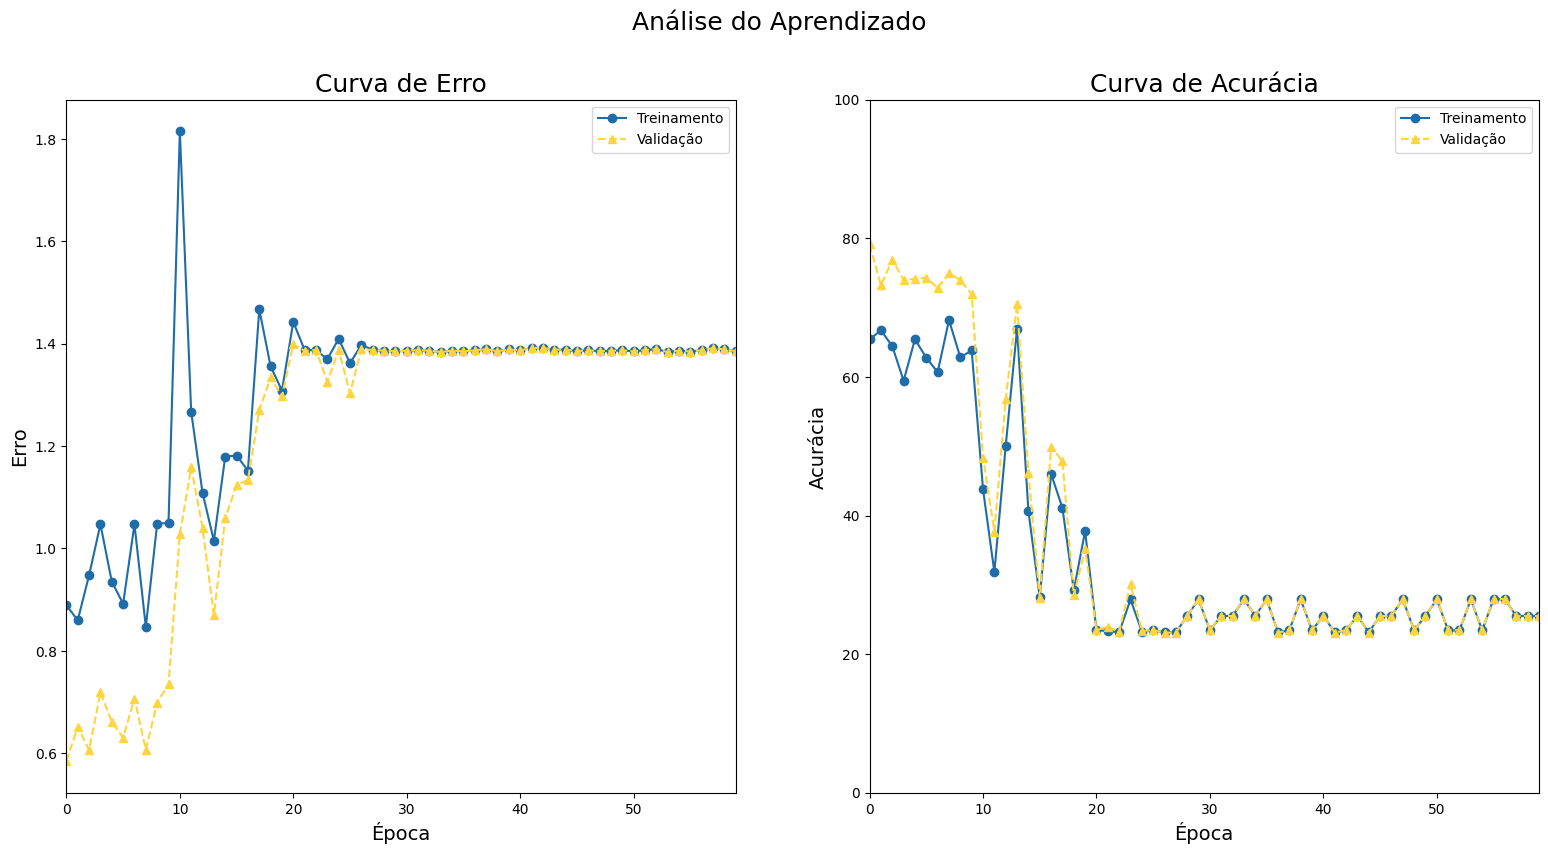

In [27]:
plot_analysis(epoch_metrics, save_as=f"{trainer.logger.log_dir}/{model.name}-analysis.png")

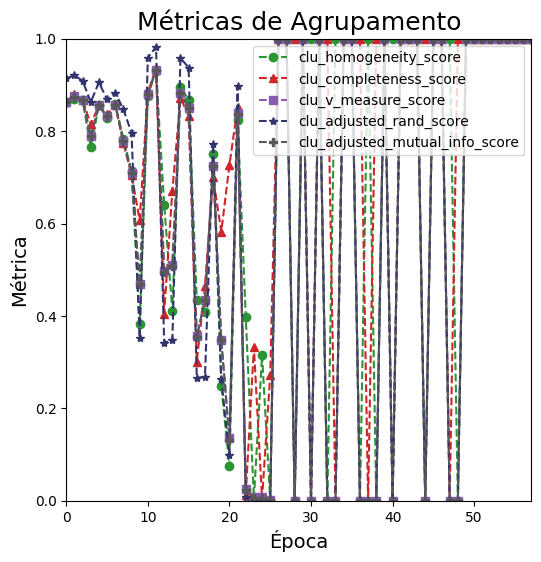

In [28]:
plot_clustering_metrics(clustering_metrics[1:], show=True, save_as=f"{trainer.logger.log_dir}/{model.name}-clustering.png")

In [29]:
plot_loss_curve(epoch_metrics, show=False, save_as=f"{trainer.logger.log_dir}/{model.name}-loss.png")
plot_acc_curve(epoch_metrics, show=False, save_as=f"{trainer.logger.log_dir}/{model.name}-acc.png")
basic_report(truth_labels, preds_labels, labels=[0,1,2,3], label_names=["Glioma", "Meningioma", "Sem Tumor", "Pituitária"], show=False, 
             save_as=f"{trainer.logger.log_dir}/{model.name}-confusion-matrix.png")

              precision    recall  f1-score   support

      Glioma      0.000     0.000     0.000       300
  Meningioma      0.000     0.000     0.000       306
   Sem Tumor      0.000     0.000     0.000       405
  Pituitária      0.229     1.000     0.372       300

    accuracy                          0.229      1311
   macro avg      0.057     0.250     0.093      1311
weighted avg      0.052     0.229     0.085      1311

            Gli  Men  Sem  Pit
Glioma        0    0    0  300
Meningioma    0    0    0  306
Sem Tumor     0    0    0  405
Pituitária    0    0    0  300


In [30]:
from collections import Counter

In [31]:
Counter(truth_labels)

Counter({2: 405, 1: 306, 0: 300, 3: 300})

In [ ]:
Counter(preds_labels)

Counter({3: 1311})